# O que é a Lei Rouanet

A Lei Rouanet, oficialmente denominada Lei 8.313/91, é o principal mecanismo de fomento à cultura no Brasil, instituindo o Programa Nacional de Apoio à Cultura (Pronac). Seu nome é uma homenagem ao seu idealizador, o diplomata Sérgio Paulo Rouanet, então secretário Nacional de Cultura. Essa legislação estabelece as diretrizes para o Governo Federal disponibilizar recursos destinados à realização de projetos artístico-culturais. Originalmente, a Lei Rouanet foi concebida com três mecanismos: o Fundo Nacional da Cultura (FNC), o Incentivo Fiscal e o Fundo de Investimento Cultural e Artístico (Ficart). No entanto, o Ficart nunca foi implementado, enquanto o Incentivo Fiscal, também conhecido como mecenato, se destacou e, muitas vezes, é erroneamente associado como sendo a própria Lei Rouanet.

###

# Sobre o projeto

Este projeto oferece a oportunidade de compreender melhor a distribuição de recursos culturais por meio da Lei Rouanet e extrair insights significativos sobre a diversidade e impacto dos projetos financiados. 

**Objetivo do projeto**

Realizar uma análise exploratória de dados (EDA) no conjunto de dados da Lei Rouanet (2009-2024), buscando compreender padrões, tendências e insights relacionados aos projetos culturais financiados por meio dessa lei de incentivo à cultura no Brasil.

## Passos do projeto

### 1. Coletar e Carregar os Dados

- Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)
- Carregar os dados em um DataFrame do pandas.

### 2. Realizar uma Exploração Inicial

- Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.

### 3. Limpar e preparar os dados

- Tratar valores ausentes, inconsistências ou duplicatas.
- Analisar, criar e ajustar categorias relevantes.

### 4. Analisar

**4.1. Segmentação por áreas culturais**

- Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).
- Verificar a distribuição das áreas ao longo dos anos

**4.2. Participação geográfica**

- Visualizar a participação geográfica dos projetos. Qual região do Brasil recebeu mais incentivos culturais?

**4.3. Representividade sociocultural**

- Analisar se e como as minorias foram beneficiadas.

**4.4. Tipos de financiamento**

- Explorar os mecanismos de incentivo à cultura.
- Explorar os cálculos de isenção fiscal

**4.5. Distribuição de recursos**

- Analisar a dificuldade na captação de recursos.
- Analisar a distribuição de recursos por categoria.
- Analisar a distribuição de recursos por região.
- Explorar a distribuição de recursos financeiros ao longo do tempo.
- Identificar os projetos que receberam a maior e menor quantidade de financiamento.

**4.6. Influência de grandes projetos**

- Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?

**4.7. Recorte dos últimos anos**

- Refazer algumas análises anteriores considerando apenas os últimos X anos.

<!-- **4.8. Análise de sucesso**

- Definir critérios para o sucesso de um projeto (por exemplo, avaliação do público, impacto cultural) e explorar quais características estão associadas a projetos bem-sucedidos. -->

### 5. Concluir

- Resumir as principais descobertas do projeto.
- Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.

## Ferramentas utilizadas

- Python (`pandas`, `numpy`, `geobr`, `matplotlib` e `seaborn`)
- Jupyter Notebook para documentação e visualização interativa.

###

# Análise de Dados Exploratória

<!-- Fontes:
- https://www.linkedin.com/pulse/entenda-o-que-%C3%A9-lei-rouanet-ficarte-fnc-e-oque-fiscal-oliveira/?originalSubdomain=pt
- https://www.gov.br/cultura/pt-br/centrais-de-conteudo/marcas-e-logotipos/copy_of_ManualdoProponenteMduloIApresentaodePropostas1.pdf
- https://portaldoincentivo.com.br/visitors/incentive_laws/1 -->

### 1. Coletar e Carregar os Dados

**Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)**

Eu desenvolvi um script utilizando as bibliotecas `os`, `request`, `json` e `pandas` para extrair os dados da API referentes aos projetos, propostas, proponentes, incentivadores e fornecedores. Os dados foram salvos em arquivos no formato `xsls`. Devido ao seu tamanho, não foi possível hospedá-los neste repositório. Em vez disso, eu os incluí em uma pasta no Google Drive e compartilhei os links em um arquivo `csv`. 

Esses arquivos podem ser baixados manualmente ou usando um script que criei com as bibliotecas `os` e `gdown`. 

**Carregar os dados em um DataFrame do pandas.**

In [1]:
from os import path

import numpy as np
import pandas as pd

import geobr
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
projetos = pd.read_excel(path.abspath("datasets/projetos.xlsx"))
# propostas = pd.read_excel(path.abspath("datasets/propostas.xlsx"))
# proponentes = pd.read_excel(path.abspath("datasets/proponentes.xlsx"))
# incentivadores = pd.read_excel(path.abspath("datasets/incentivadores.xlsx"))
# fornecedores = pd.read_excel(path.abspath("datasets/fornecedores.xlsx"))

####

### 2. Realizar uma Exploração Inicial

**Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.**

In [3]:
projetos.columns

Index(['etapa', 'providencia', 'area', 'enquadramento', 'objetivos',
       'ficha_tecnica', 'situacao', 'outras_fontes', 'acessibilidade',
       'sinopse', 'nome', 'cgccpf', 'mecanismo', '_links', 'segmento',
       'PRONAC', 'estrategia_execucao', 'valor_aprovado', 'justificativa',
       'resumo', 'valor_solicitado', 'especificacao_tecnica', 'municipio',
       'data_termino', 'UF', 'impacto_ambiental', 'democratizacao',
       'valor_projeto', 'proponente', 'ano_projeto', 'data_inicio',
       'valor_captado', 'valor_proposta'],
      dtype='object')

Colunas interessantes para a análise dos **projetos**: 

- `providencia` `situacao`
- `area` `segmento`
- `mecanismo` `enquadramento`
- `valor_aprovado` `valor_projeto` `valor_captado` `valor_proposta`
- `UF` `municipio`
- `ano_projeto` `data_termino` `data_inicio`
- `impacto_ambiental`
- `proponente`
- `_links`

In [4]:
# propostas.columns

Colunas interessantes para a análise das **propostas**: 

- `data_arquivamento` `data_aceite` `data_termino`
- `mecanismo`

In [5]:
# proponentes.columns

Colunas interessantes para a análise dos **proponentes**: 

- `tipo_pessoa`
- `responsavel`
- `UF` `municipio`
- `total_captado`

In [6]:
# incentivadores.columns

Colunas interessantes para a análise dos **incentivadores**: 

- `nome` `tipo_pessoa` `responsavel`
- `total_doado`
- `UF` `municipio`
- `_links`

In [7]:
# fornecedores.columns

Colunas interessantes para a análise dos **incentivadores**: 

- `nome`
- `_links`

####

### 3. Limpar e preparar os dados

**Tratar valores ausentes, inconsistências ou duplicatas.**

Reduzindo os dfs para conter apenas as informações necessárias:

In [8]:
projetos = projetos[["objetivos", "providencia", "situacao", "area", "segmento", "mecanismo", "enquadramento",
                     "valor_aprovado", "valor_projeto", "valor_captado", "valor_proposta",
                     "UF", "municipio", "ano_projeto", "data_termino", "data_inicio",
                     "impacto_ambiental", "proponente", "_links"]].sort_values("ano_projeto")

# propostas = propostas[["data_arquivamento", "data_aceite", "data_termino", "mecanismo"]].sort_values(by="data_aceite")

# proponentes = proponentes[["tipo_pessoa", "responsavel", "UF", "municipio", "total_captado"]].sort_values("total_captado", ascending=False)

# incentivadores = incentivadores[["nome", "tipo_pessoa", "responsavel", "total_doado", "UF", "municipio", "_links"]]

# fornecedores = fornecedores[["nome", "_links"]]

In [9]:
# removendo valores negativos
projetos = projetos[projetos["valor_projeto"] >= 0]
projetos = projetos[projetos["valor_aprovado"] >= 0]

# removendo 1 de 33119 projetos de uma área diferente
filtro_mecanismo_fnc = projetos["mecanismo"] == "FNC"
filtro_area_audiovisual = projetos["area"] == "Audiovisual"
projetos = projetos[~(filtro_mecanismo_fnc & filtro_area_audiovisual)] 

# padronizando ano para formato 20XX
filtro_ano_menor_igual_24 = (projetos["ano_projeto"] <= 24).all()

if filtro_ano_menor_igual_24.all():
    projetos["ano_projeto"] = 2000 + projetos["ano_projeto"]

# remover ano de 2024 por dados insuficientes
filtro_ano_2024 = projetos["ano_projeto"] == 2024
projetos = projetos[~filtro_ano_2024]

# ajustando index após remoções
projetos.set_index(np.arange(0, projetos.shape[0]), inplace=True)

Tratamento dos dados das propostas:

In [10]:
# propostas = propostas[propostas[["data_arquivamento", "data_aceite", "data_termino"]].any(axis=1)]

Tratamento dos dados dos proponentes:

In [11]:
# uf_invalidos = ["  ", "35", "33", "41", "51", "15", "26", "53"]
# proponentes = proponentes[~(proponentes["UF"].str.contains("|".join(uf_invalidos))) & ~(proponentes["responsavel"] == '.')]

Tratamento dos dados dos incentivadores:

In [12]:
# uf_invalidos = ["  ", "13", "15", "17", "21", "22", "23", "25", "26", "27", "28", "29", "31", "32", "33", "35", "41", "42", "43", "50", "51", "52", "53", "NI"]
# incentivadores = incentivadores[~incentivadores["UF"].str.contains("|".join(uf_invalidos))]

Os dados dos fornecedores não requerem tratamento.

#####

**Analisar, criar e ajustar categorias relevantes.**

Dividir estados por regiões do Brasil:

In [13]:
def regiao_do_uf(uf):
    regioes = {
        "Centro Oeste": ["DF", "GO", "MS", "MT"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Norte": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"]
    }
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao

regioes = pd.Series(projetos["UF"].apply(regiao_do_uf), name="regiao")

if "regiao" not in projetos.columns:
    projetos = pd.concat([projetos, regioes], axis=1)

In [14]:
minorias = ["afro", "áfrica", "africa", "quilombola", "pessoas negras", "homem negro", "homem preto", "mulher negra", "mulher preta", "homens negros", "homens pretos", "mulheres negras", "mulheres pretas", 
            "índio", "indio", "povos originários", "povos originarios", "indígena", "indigena", "caiçara", 
            "baixa renda", "favela", "periferia", "pobre", "pessoas em situação de rua", "situação de vulnerabilidade", "mendigo",
            "mulher", "feminino",
            "homossex", "homofobia", "lgbt", "gay", "lésbica", "bissexua", "pessoas trans", "mulheres trans", "homens trans", "transsexua", "transgênero", "transgenero", "queer",
            "pcd", "deficiência", "deficiencia", "deficiente", 
            "idoso", "idosa", "maior idade",
            "imigrante", "cigano", "cigana", "refugiado",
            "minoria"
           ]

filtro1 = projetos["objetivos"].isnull()
filtro2 = projetos["objetivos"].str.lower().str.contains("|".join(minorias))

arr_falsos = np.array([False for _ in range(projetos.shape[0])])
voltado_para_minorias = pd.Series(arr_falsos, name="voltado_para_minorias")
voltado_para_minorias[projetos[~filtro1 & filtro2].index] = True

if "voltado_para_minorias" not in projetos.columns:
    projetos = pd.concat([projetos, voltado_para_minorias], axis=1)

####

### 4. Analisar

#### 4.1. Segmentação por áreas culturais

**Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).**

Inicialmente, realizei as contagens dos projetos segmentados por áreas.

In [15]:
distribuicao_areas_brasil = projetos["area"].value_counts(normalize=True) * 100

areas_por_regioes = projetos.groupby("regiao")["area"].value_counts(normalize=True, sort=False) * 100
arr_areas_por_regioes = np.array(areas_por_regioes).reshape(5, -1) # 5 regiões do Brasil
arr_medias_areas_por_regioes = np.average(arr_areas_por_regioes, axis=0)

rotulos = areas_por_regioes[projetos["regiao"].iloc[0]].index
medias_areas_por_regioes = pd.Series(arr_medias_areas_por_regioes, index=rotulos).sort_values(ascending=False)

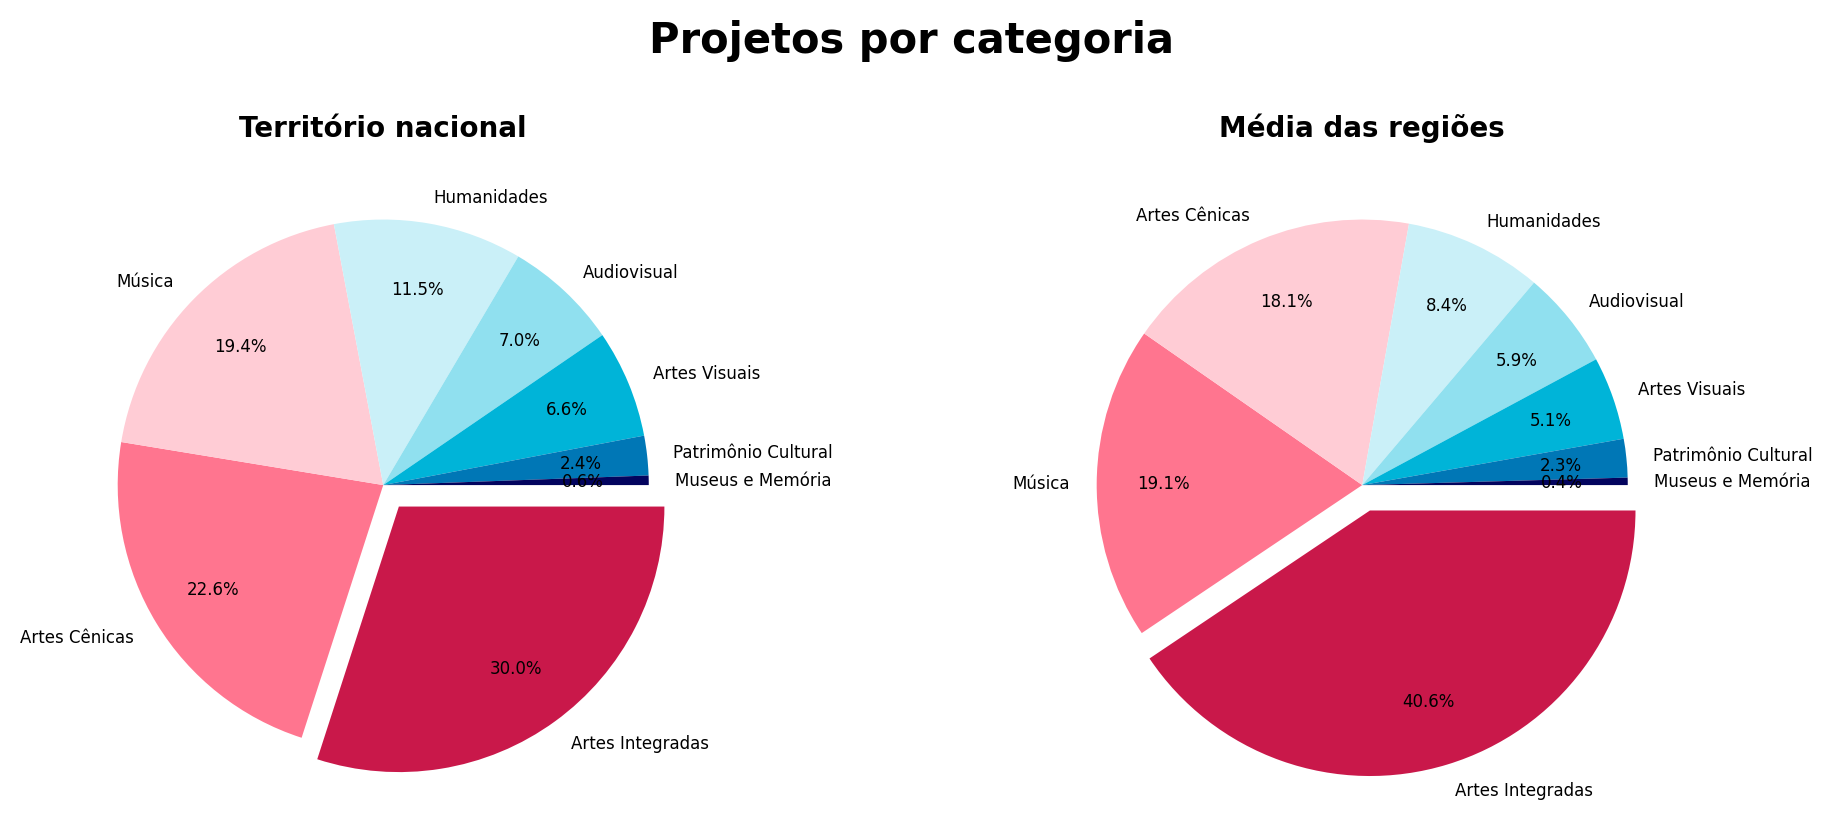

In [16]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#ff758f", "#ffccd5", "#caf0f8", 
          "#90e0ef", "#00b4d8", "#0077b6", "#03045e"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)


def plot_pizza(dados, axis):
    axis.pie(
        dados, 
        labels=dados.index, 
        autopct='%1.1f%%', 
        pctdistance=0.75,
        counterclock=False,
        colors=cores, 
        explode=separacao_fatia
    )


plot_pizza(distribuicao_areas_brasil, ax1)
plot_pizza(medias_areas_por_regioes, ax2)

fig.suptitle('Projetos por categoria', fontsize=15, fontweight=1000, y=1.02)
ax1.set_title('Território nacional', fontsize=10, fontweight=600)
ax2.set_title('Média das regiões', fontsize=10, fontweight=600)

plt.tight_layout()
plt.show()

#####

**Verificar a distribuição das áreas ao longo dos anos.**

In [17]:
anos_por_areas = projetos.groupby("area")["ano_projeto"].value_counts().sort_index()

ordenacao = medias_areas_por_regioes.argsort()[::-1]
rotulos_areas = projetos["area"].unique()[ordenacao]
rotulos_anos = projetos["ano_projeto"].unique()

anos_por_areas_todos_anos = [[anos_por_areas.get(area)[ano]
                              if ano in anos_por_areas.get(area).index else 0
                              for ano in rotulos_anos]
                             for area in rotulos_areas]

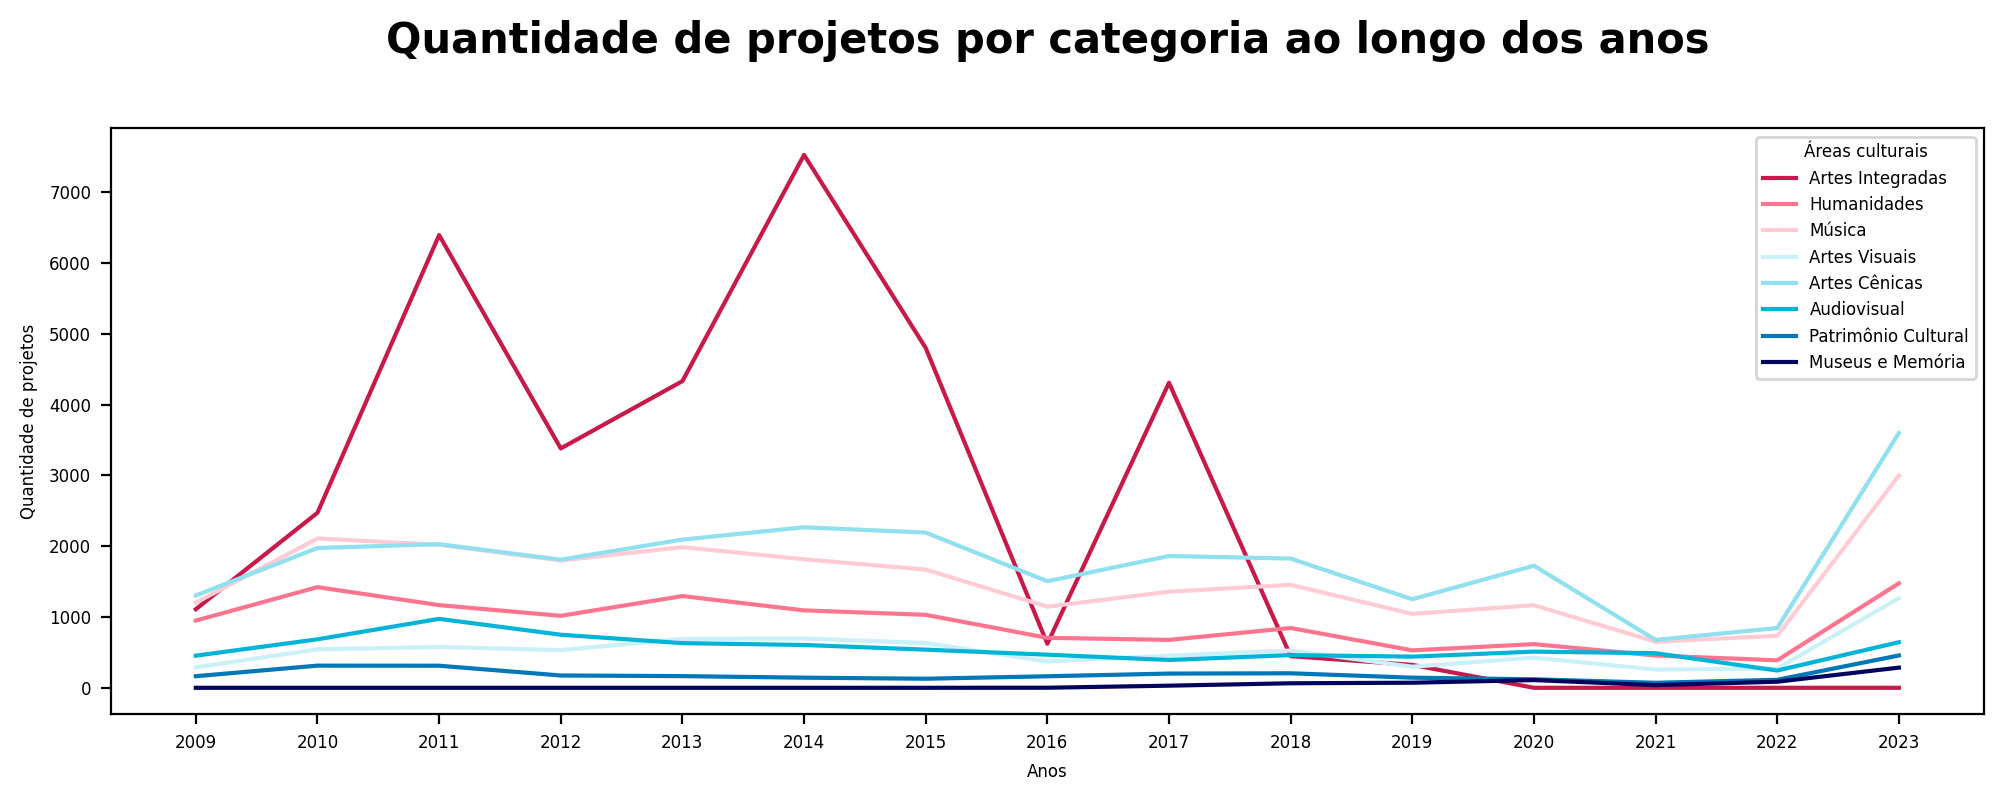

In [18]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#ff758f", "#ffccd5", "#caf0f8", 
          "#90e0ef", "#00b4d8", "#0077b6", "#03045e"]

plt.figure(figsize=(10, 4), dpi=200)

for qtd_projetos, area, cor in zip(anos_por_areas_todos_anos, rotulos_areas, cores):
    plt.plot(
        rotulos_anos,
        qtd_projetos,
        label=area,
        color=cor
    )

plt.title("Quantidade de projetos por categoria ao longo dos anos", fontsize=15, fontweight=1000, y=1.1)

plt.xlabel("Anos")
plt.ylabel("Quantidade de projetos")

plt.xticks(rotulos_anos)

plt.legend(title="Áreas culturais")

plt.tight_layout()
plt.show()

####

#### 4.2. Participação geográfica

**Visualizar a participação geográfica dos projetos.**

Inicialmente, realizei a contagem de projetos por regiões e por estados e plotei os resultados em um gráfico.

In [19]:
warnings.filterwarnings("ignore")

projetos_por_regiao = projetos["regiao"].value_counts().rename("qtd_projetos")
regioes = geobr.read_region() # Download do mapa do Brasil dividido por regiões
regioes = regioes.merge(projetos_por_regiao, how="left", left_on="name_region", right_on="regiao")

projetos_por_estados = projetos["UF"].value_counts().rename("qtd_projetos")
estados = geobr.read_country(year=2020)  # Download do mapa do Brasil dividido por estados
estados = estados.merge(projetos_por_estados, how="left", left_on="abbrev_state", right_on="UF")

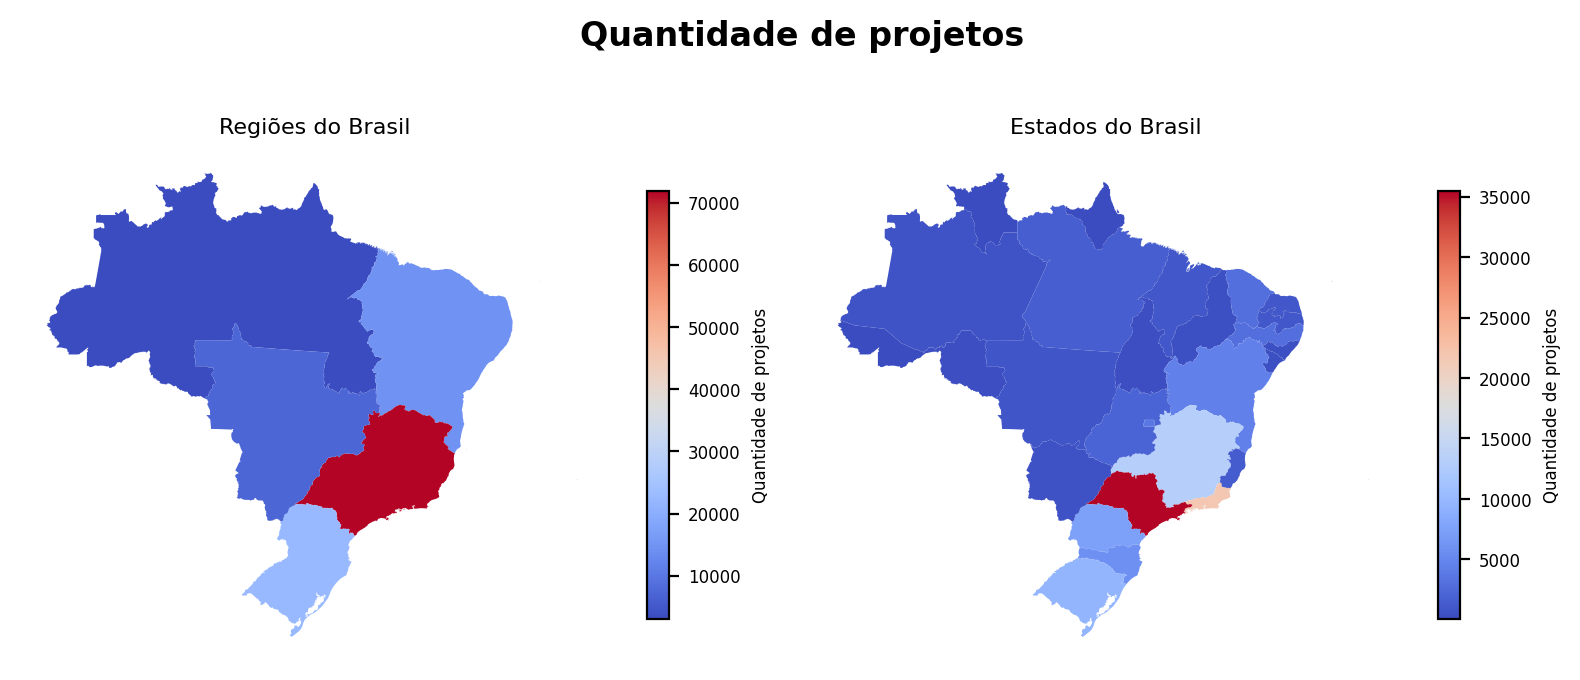

In [20]:
plt.rcParams.update({"font.size": 6})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=200)


def plot_mapa(mapa, axis):
    mapa.plot(
        column="qtd_projetos",
        cmap="coolwarm",
        legend=True,
        legend_kwds={
            "label": "Quantidade de projetos",
            "orientation": "vertical",
            "shrink": 0.6,
        },
        ax=axis,
    )

    axis.axis("off")


plot_mapa(regioes, axs[0])
plot_mapa(estados, axs[1])

fig.suptitle('Quantidade de projetos', fontsize=12, fontweight=1000, y=0.95)
axs[0].set_title("Regiões do Brasil", fontsize=8)
axs[1].set_title("Estados do Brasil", fontsize=8)

plt.tight_layout()
plt.show()

In [21]:
warnings.filterwarnings("default")

####

#### 4.3. Representividade sociocultural

**Analisar se e como as minorias foram beneficiadas.**

In [319]:
warnings.filterwarnings("ignore")

projetos_minorias = projetos["voltado_para_minorias"].value_counts()


projetos_por_ano_minorias = projetos.groupby("ano_projeto")["voltado_para_minorias"].value_counts()
rotulos_anos = projetos_por_ano_minorias.index.get_level_values('ano_projeto')
rotulos_anos_geral, rotulos_anos_minorias = np.array(rotulos_anos).reshape(-1, 2).T
valores_anos_geral, valores_anos_minorias = projetos_por_ano_minorias.values.reshape(-1, 2).T

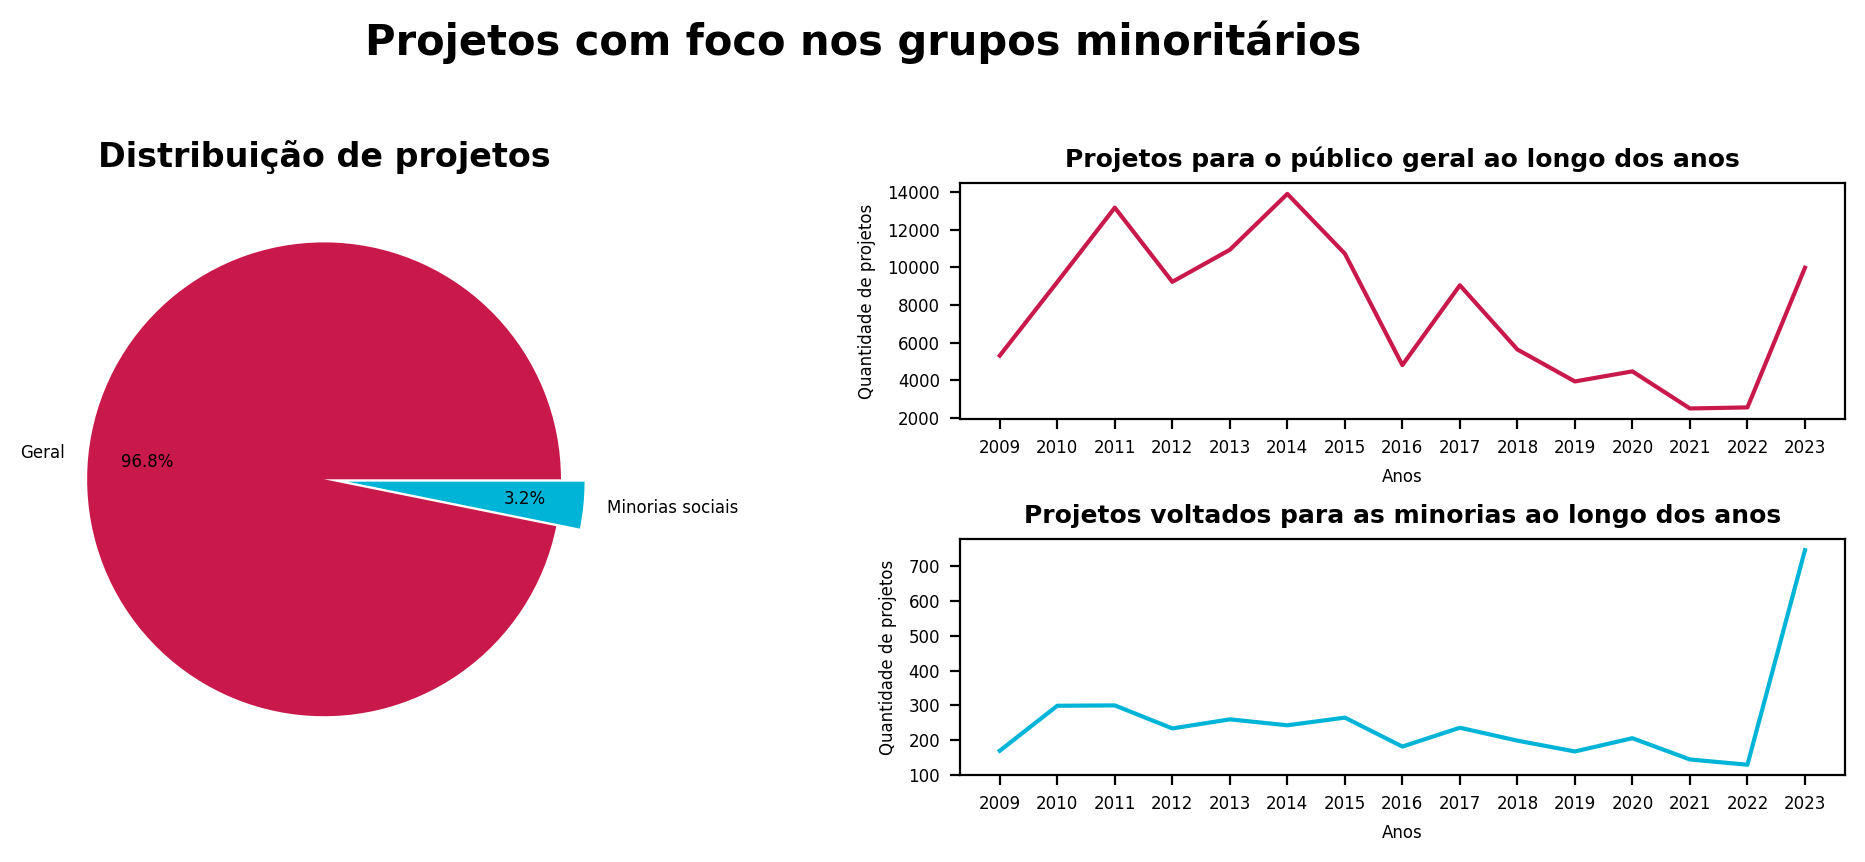

In [337]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#00b4d8"]
separacao_fatia = (0, 0.1)

fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['a)', 'c)']], layout='constrained', figsize=(10, 4), dpi=200)

for i, (_, ax) in enumerate(axs.items(), 1):
    if i == 1:
        ax.pie(
            projetos_minorias,
            labels=["Geral", "Minorias sociais"],
            autopct="%1.1f%%",
            pctdistance=0.75,
            colors=cores,
            explode=separacao_fatia
        )
        
        ax.set_title("Distribuição de projetos", fontsize=12, fontweight=600)
    elif i == 2:
        ax.plot(
            rotulos_anos_geral,
            valores_anos_geral,
            color=cores[0]
        )
        
        ax.set_title("Projetos para o público geral ao longo dos anos", fontsize=9, fontweight=600)
        
        ax.set_xlabel("Anos")
        ax.set_ylabel("Quantidade de projetos")

        ax.set_xticks(rotulos_anos_geral)
        
    else:
        ax.plot(
            rotulos_anos_minorias,
            valores_anos_minorias,
            color=cores[1]
        )
        
        ax.set_title("Projetos voltados para as minorias ao longo dos anos", fontsize=9, fontweight=600)

        ax.set_xlabel("Anos")
        ax.set_ylabel("Quantidade de projetos")

        ax.set_xticks(rotulos_anos_minorias)

plt.suptitle("Projetos com foco nos grupos minoritários", fontsize=15, fontweight=1000, y=1.05)

plt.tight_layout()

plt.show()

In [341]:
warnings.filterwarnings("default")

In [342]:
minorias_por_area = projetos[projetos["voltado_para_minorias"] == True]["area"].value_counts().sort_values(ascending=False)
minorias_por_regiao = projetos[projetos["voltado_para_minorias"] == True]["regiao"].value_counts().sort_values(ascending=False)

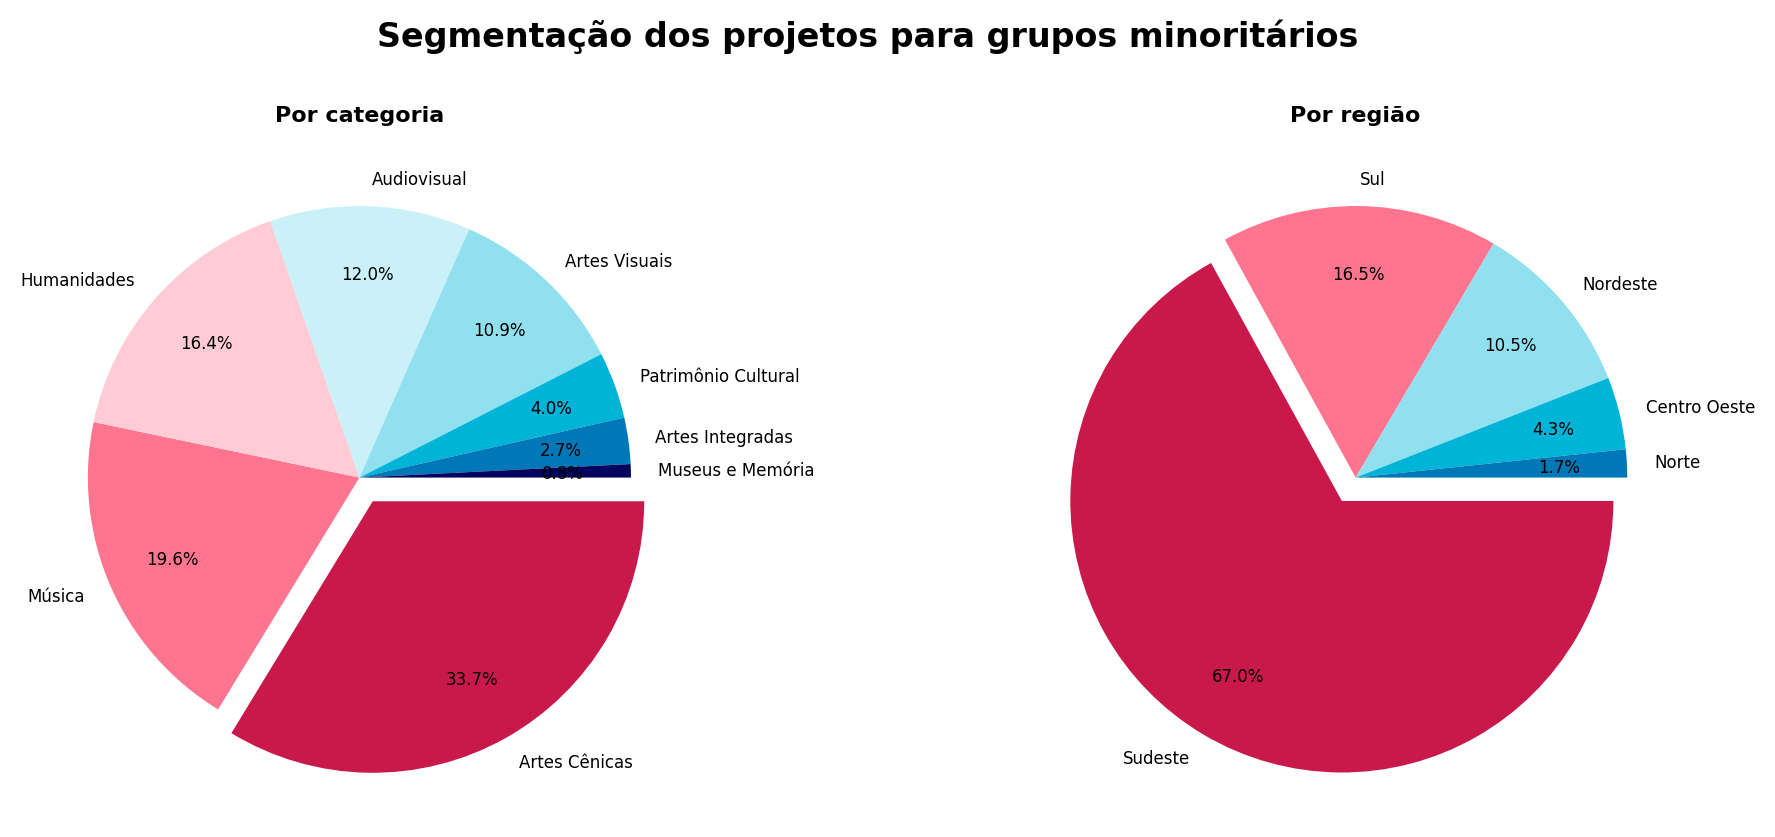

In [343]:
plt.rcParams.update({"font.size": 6})
cores_area = ["#c9184a", "#ff758f", "#ffccd5", "#caf0f8", 
              "#90e0ef", "#00b4d8", "#0077b6", "#03045e"]
cores_regiao = ["#c9184a", "#ff758f", "#90e0ef", "#00b4d8", "#0077b6"]
separacao_fatia_area = (0.1, 0, 0, 0, 0, 0, 0, 0)
separacao_fatia_regiao = (0.1, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    minorias_por_area,
    labels=minorias_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    counterclock=False,
    colors=cores_area,
    explode=separacao_fatia_area
)

ax2.pie(
    minorias_por_regiao,
    labels=minorias_por_regiao.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    counterclock=False,
    colors=cores_regiao,
    explode=separacao_fatia_regiao
)

fig.suptitle('Segmentação dos projetos para grupos minoritários', fontsize=12, fontweight=1000, y=1.02)
ax1.set_title('Por categoria', fontsize=8, fontweight=600)
ax2.set_title('Por região', fontsize=8, fontweight=600)

plt.tight_layout()
plt.show()

####

#### 4.4. Tipos de financiamentos

**Explorar os mecanismos de incentivo à cultura.**

Sobre os mecanismos utilizados pela Lei Rouanet:

- Incentivo Fiscal (mecenato)

O incentivo é um mecanismo em que a União faculta às pessoas físicas ou jurídicas a opção pela aplicação de parcelas do Imposto sobre a Renda, a título de doações ou patrocínios, no apoio direto a projetos culturais aprovados pelo Ministério da Cultura. Ou seja: o Governo Federal oferece uma ferramenta para que a sociedade possa decidir aplicar parte do dinheiro de seus impostos em ações culturais. Desta maneira, o incentivo fiscal estimula a participação da iniciativa privada, do mercado empresarial e dos cidadãos no aporte de recursos para o campo da cultura, diversificando possibilidades de financiamento, ampliando o volume de recursos destinados ao setor, atribuindo a ele mais potência e mais estratégia econômica.

- Fundo Nacional da Cultura (FNC)

O Fundo Nacional da Cultura (FNC) representa o investimento direto do Estado no fomento à Cultura, já que o apoio a projetos decorre de recursos do orçamento da União dentre outras fontes, como 3% do valor bruto arrecado pelas loterias federais e doações. O apoio via FNC tem como objetivo promover a distribuição regional dos recursos de forma equilibrada e é voltado aos projetos com maior dificuldade de captação junto ao mercado.

**Filtros:**

In [22]:
filtro_mecanismo_mecenato = projetos["mecanismo"] == "Mecenato"
filtro_mecanismo_fnc = projetos["mecanismo"] == "FNC"

situacao_captacao_projetos = ["Arquivado - por excesso de prazo sem captação", 
                              "Projeto encerrado por excesso de prazo sem captação", 
                              "Arquivado - atingiu 24 meses de aprovação sem captação de recursos", 
                              "Projeto não executado por insuficiência de captação de recursos"]

filtro_situacao_dificuldade_captacao = projetos["situacao"].str.contains("|".join(situacao_captacao_projetos))

**Análises:**

In [23]:
mecanismos = projetos["mecanismo"].value_counts(normalize=True) * 100

mecenato_por_anos = projetos[filtro_mecanismo_mecenato]["ano_projeto"].value_counts().sort_index()
fnc_por_anos = projetos[filtro_mecanismo_fnc]["ano_projeto"].value_counts().sort_index()

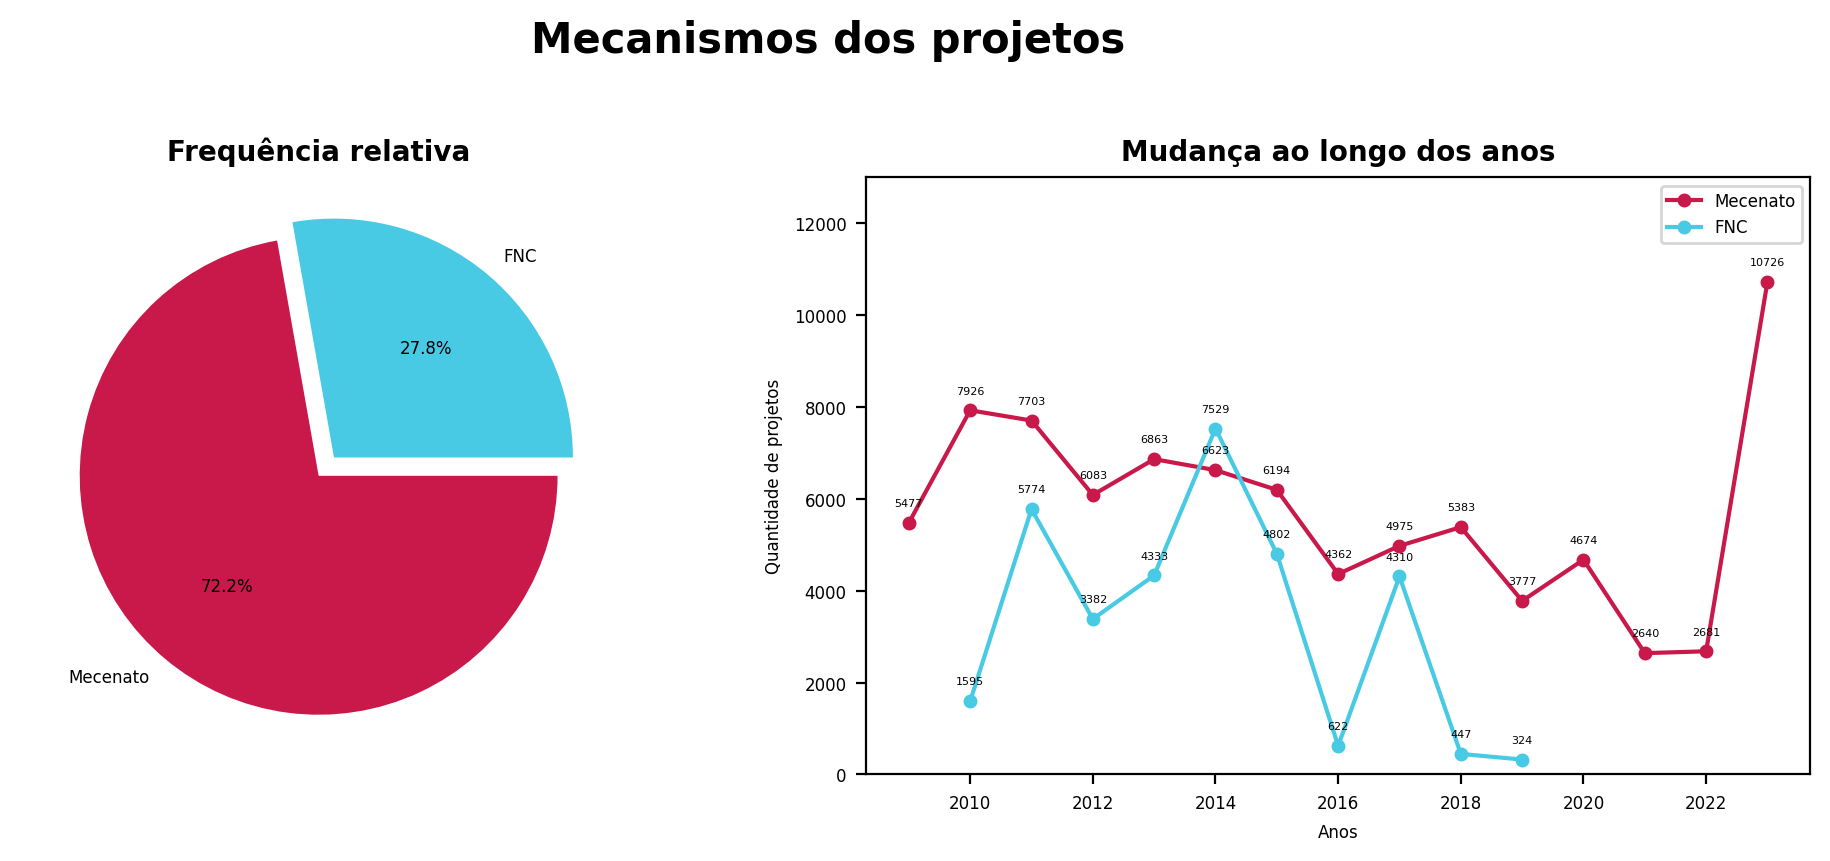

In [24]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#48cae4"]
separacao_fatia = (0, 0.1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    mecanismos,
    labels=mecanismos.index,
    autopct="%1.1f%%",
    counterclock=False,
    colors=cores,
    explode=separacao_fatia
)

ax2.plot(
    mecenato_por_anos.index, 
    mecenato_por_anos, 
    cores[0],
    
    fnc_por_anos.index,
    fnc_por_anos,
    cores[1],
    
    marker="o",
    markersize=4
)


def rotulos_pontos(arr_index, arr, ax):
    for x, y in zip(arr_index, arr):
        rotulo = "{}".format(y)
        ax.annotate(
            rotulo,
            (x, y),
            textcoords="offset points",
            xytext=(0, 6),
            fontsize=4,
            ha='center'
        )


rotulos_pontos(mecenato_por_anos.index, mecenato_por_anos, ax2)
rotulos_pontos(fnc_por_anos.index, fnc_por_anos, ax2)

plt.suptitle("Mecanismos dos projetos", fontsize=15, fontweight=1000, y=1.05)
ax1.set_title("Frequência relativa", fontsize=10, fontweight=600)
ax2.set_title("Mudança ao longo dos anos", fontsize=10, fontweight=600)

plt.xlabel("Anos")
plt.ylabel("Quantidade de projetos")

ax2.legend(["Mecenato", "FNC"])

plt.ylim(bottom=0, top=13000)

plt.tight_layout()
plt.show()

Ao longo dos anos, a maior fatia dos projetos foi financiada pelo mecenato, sendo que o financiamento pelo estado ocorreu em 27,7% dos projetos.

Curiosamente, as Artes Integradas, área que representa a maior quantidade de projetos no Brasil e suas respectivas regiões, tem a grande maioria de seus projetos financiados pelo Estado. Segundo os dados, além das Artes Integradas, apenas 1 outro projeto foi financiado com o mecanismo do FNC, na área de Audiovisual. O restante dos projetos foram financiados via mecenato. Este projeto de Audiovisual será considerado uma anomalia e descartado para esta análise.

In [25]:
# por area
mecenatos_por_area = projetos[filtro_mecanismo_mecenato]["area"].value_counts().sort_values(ascending=False)
fnc_por_area = projetos[filtro_mecanismo_fnc]["area"].value_counts()

# por regiao
mecenato_por_regiao = projetos[filtro_mecanismo_mecenato]["regiao"].value_counts().sort_index()
fnc_por_regiao = projetos[filtro_mecanismo_fnc]["regiao"].value_counts().sort_index()

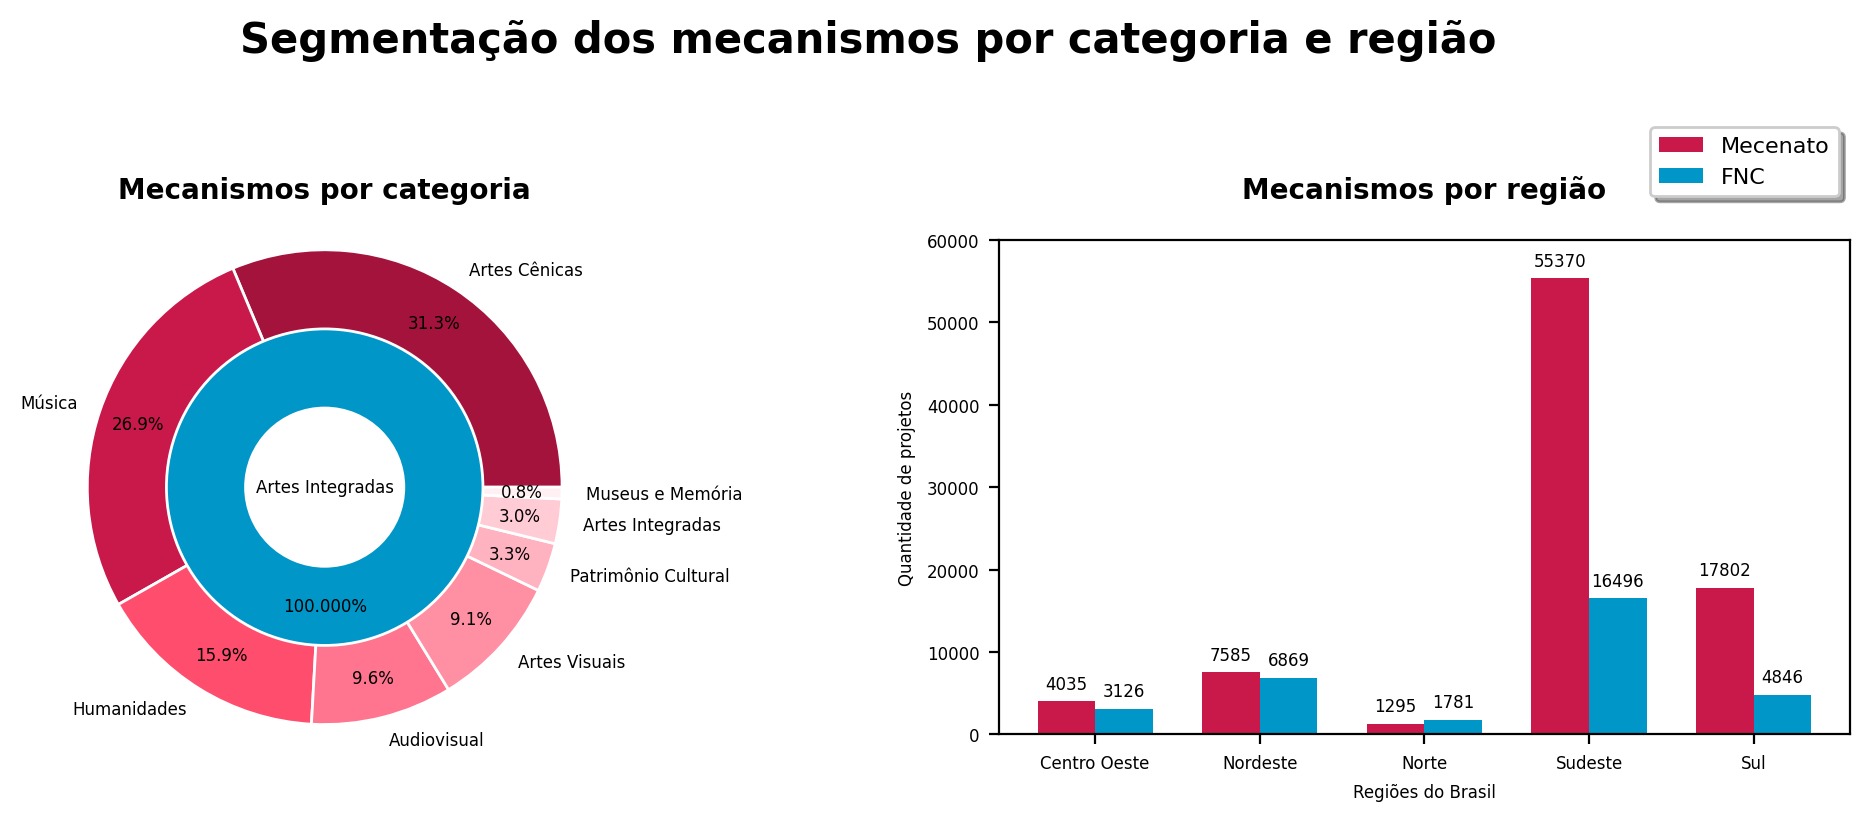

In [27]:
plt.rcParams.update({"font.size": 6})
cores_mecenato = ["#a4133c", "#c9184a", "#ff4d6d", "#ff758f", 
          "#ff8fa3", "#ffb3c1", "#ffccd5", "#fff0f3"]
cor_fnc = ["#0096c7"]
cores = ["#c9184a", "#0096c7"]
rotulos = mecenato_por_regiao.index
localizacao_rotulos = np.arange(len(rotulos))
largura = 0.35

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    mecenatos_por_area,
    labels=mecenatos_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.83,
    radius=1.2, 
    wedgeprops={"width": 0.5, "edgecolor": 'w'},
    colors=cores_mecenato
)

ax1.pie(
    fnc_por_area,
    labels=fnc_por_area.index,
    labeldistance=0,
    startangle=90,
    autopct="%1.3f%%",
    pctdistance=0.75,
    radius=0.8,
    wedgeprops={"width": 0.4, "edgecolor": 'w'},
    textprops={"ha": "center"},
    colors=cor_fnc
)


def plot_barra(localizacao, dados, rotulo, cor, ax):
    
    if localizacao == "esquerda":
        xco = localizacao_rotulos - largura / 2
    elif localizacao == "direita":
        xco = localizacao_rotulos + largura / 2
    
    barra = ax.bar(
        x=xco, 
        height=dados, 
        width=largura, 
        label=rotulo, 
        color=cor
    )

    return barra


def autolabel(barras, ax):
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(
            text=f'{altura}',
            xy=(barra.get_x() + barra.get_width() / 2, altura),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom'
        )


barras1 = plot_barra("esquerda", mecenato_por_regiao, "Mecenato", cores[0], ax2)
barras2 = plot_barra("direita", fnc_por_regiao, "FNC", cores[1], ax2)

autolabel(barras1, ax2)
autolabel(barras2, ax2)

fig.suptitle("Segmentação dos mecanismos por categoria e região", fontsize=15, fontweight=1000, y=1)
ax1.set_title("Mecanismos por categoria", fontsize=10, fontweight=600, y = 1.05)
ax2.set_title("Mecanismos por região", fontsize=10, fontweight=600, y = 1.05)

ax2.set_xlabel("Regiões do Brasil")
ax2.set_ylabel("Quantidade de projetos")

ax2.set_xticks(localizacao_rotulos)
ax2.set_xticklabels(rotulos)

ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.25),
          fancybox=True, shadow=True, fontsize=8)

ax2.set_ylim(top=60000)

plt.tight_layout()
plt.show()

Em relação à divisão regional, percebe-se que os empresários financiam mais projetos no sul e sudeste (de forma expressiva). No Norte, o FNC ultrapassa o Incentivo Fiscal como mecanismo, enquanto no Nordeste e Centro Oeste ambos mecanismos estão em patamares próximos.

#####

**Explorar os cálculos de isenção fiscal**

Projetos aprovados no Artigo 18 da Lei Rouanet podem ser patrocinados com 100% de isenção fiscal, tanto por pessoa jurídica quanto física, enquanto projetos aprovados no Artigo 26 da Lei Rouanet oferecem os seguintes limites de isenção fiscal:

Pessoa Jurídica

- 40% do valor incentivado, no caso de doação.
- 30% do valor incentivado, no caso de patrocínio.

Pessoa Física

- 80% do valor incentivado, no caso de doação.
- 60% do valor incentivado, no caso de patrocínio.

Abeixo está uma relação sobre os projetos enquadrados

In [28]:
projetos.groupby("mecanismo")["enquadramento"].value_counts()

mecanismo  enquadramento 
FNC        Nao enquadrado    33118
Mecenato   Artigo 18         71879
           Artigo 26         11989
           Nao enquadrado     2219
Name: count, dtype: int64

####

#### 4.5. Distribuição de recursos

**Analisar a dificuldade na captação de recursos.**

É preciso considerar que apenas projetos cujo mecanismo é o Mecenato possuem a etapa de captação de recursos na hora de calcular a porcentagem de projetos que tiveram dificuldade em captar recursos em relação ao total de projetos. 

Logo, foram considerados no cálculo apenas aqueles cujo mecanismo é o Incentivo Fiscal, vulgo mecenato.

In [29]:
dificuldade_captacao_recursos = projetos[filtro_situacao_dificuldade_captacao]
projetos_via_mecenato_area = projetos[filtro_mecanismo_mecenato]["area"].value_counts().sort_index()
dificuldade_captacao_recursos_area = dificuldade_captacao_recursos["area"].value_counts().sort_index()
dificuldade_area_sobre_total = dificuldade_captacao_recursos_area / projetos_via_mecenato_area * 100

valores_por_area = dificuldade_captacao_recursos.groupby("area")["valor_aprovado"].sum().sort_values(ascending=False)

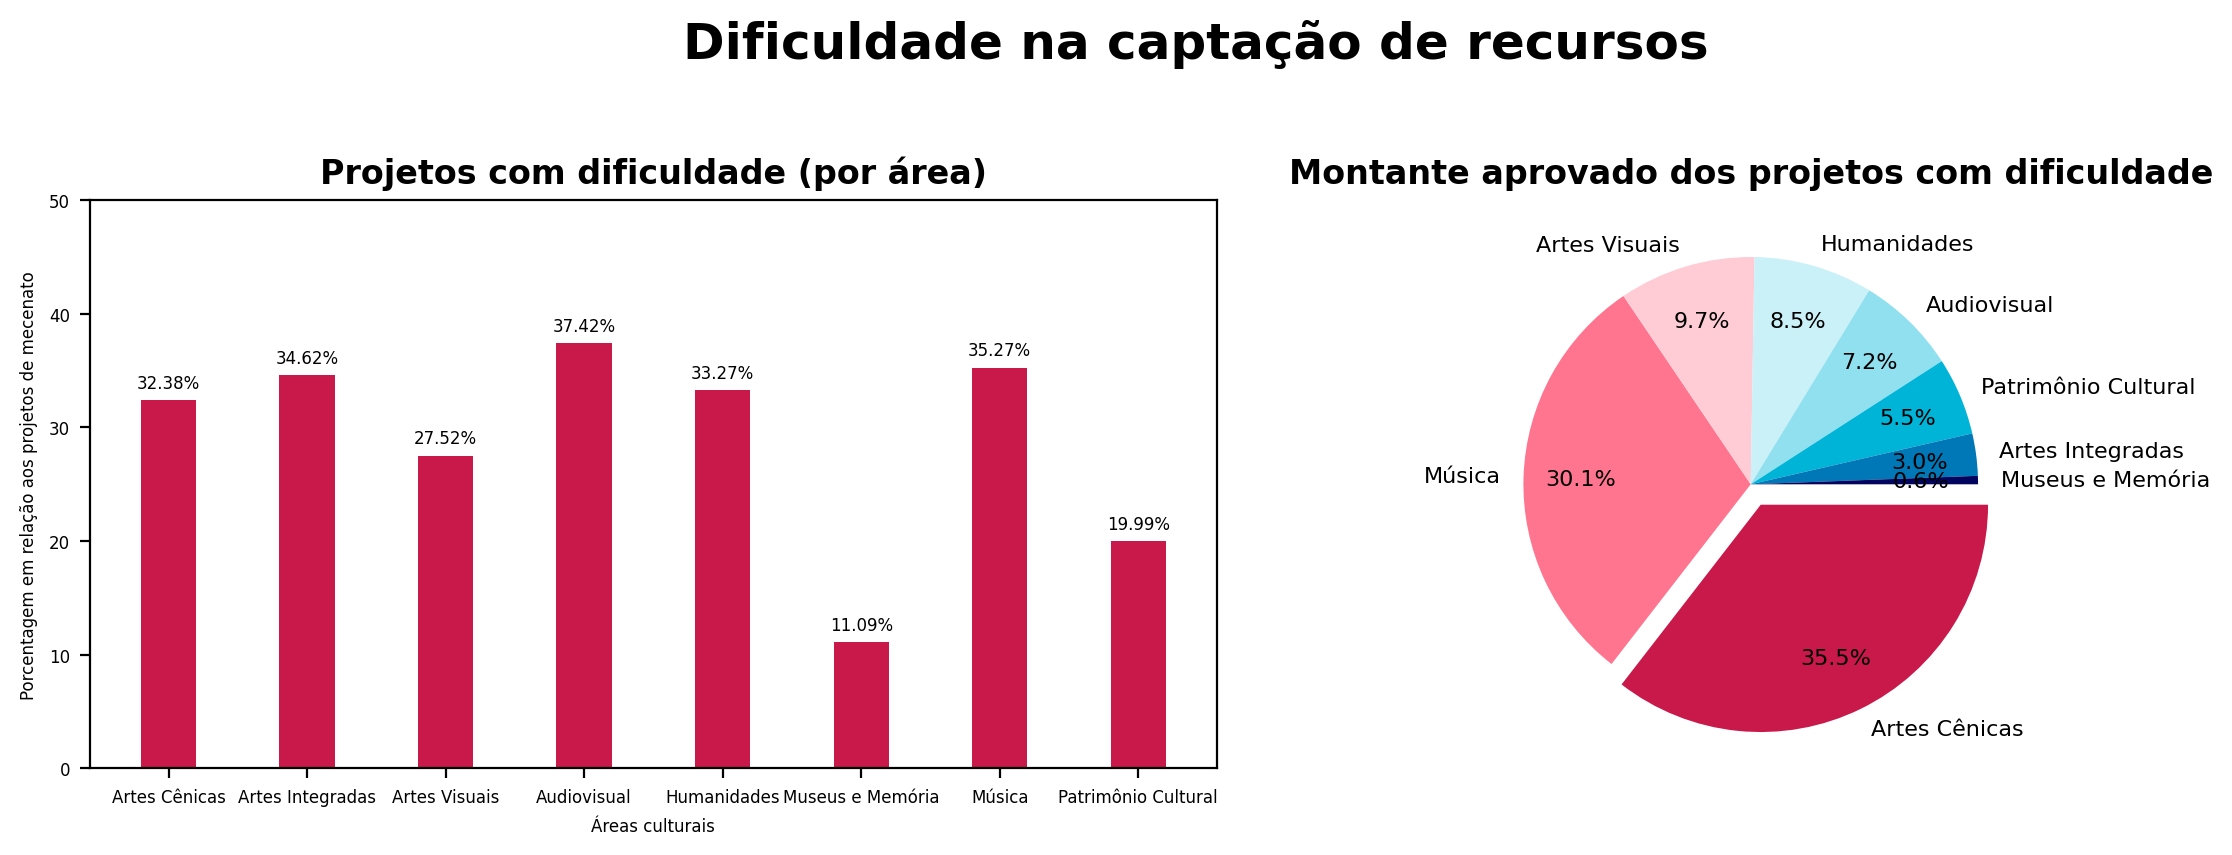

In [30]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#ff758f", "#ffccd5", "#caf0f8", 
          "#90e0ef", "#00b4d8", "#0077b6", "#03045e"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=200)

barras = ax1.bar(
    dificuldade_area_sobre_total.index,
    dificuldade_area_sobre_total, 
    color=cores[0], 
    width=0.4,
)

for barra in barras:
    altura = barra.get_height()
    ax1.annotate(
        text=f'{altura:.2f}%',
        xy=(barra.get_x() + barra.get_width() / 2, altura),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom'
    )

plt.rcParams.update({"font.size": 8})

ax2.pie(
    valores_por_area,
    labels=valores_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    counterclock=False,
    colors=cores,
    explode=separacao_fatia
)

fig.suptitle("Dificuldade na captação de recursos", fontsize=18, fontweight=1000, y=1.05)
ax1.set_title('Projetos com dificuldade (por área)', fontsize=12, fontweight=600)
ax2.set_title('Montante aprovado dos projetos com dificuldade', fontsize=12, fontweight=600)
 
ax1.set_xlabel('Áreas culturais')
ax1.set_ylabel('Porcentagem em relação aos projetos de mecenato')

ax1.set_ylim(0, 50)

fig.tight_layout()
plt.show();

#####

**Analisar a distribuição de recursos por categoria.**

In [ ]:
# areas mais lucrativas (maior valor captado - média por projeto)
# areas mais caras (maior valor aprovado - média por projeto)
# areas dos 10 projetos mais caros
# areas dos 10 projetos mais baratos
# relacao entre valor aprovado e valor captado: quanto mais caro o projeto, mais dificil de captar os recursos?

#####

**Analisar a distribuição de recursos por região.**

#####

**Identificar os projetos que receberam a maior e menor quantidade de financiamento.**

#####

**Explorar a distribuição de recursos financeiros ao longo do tempo.**

####

#### 4.6. Influência de grandes projetos

**Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?**

####

#### 4.7. Recorte dos últimos anos

**Refazer algumas análises anteriores considerando apenas os últimos X anos.**

###

### 5. Concluir

**Resumir as principais descobertas do projeto.**

#####

**Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.**